<h1 id="tocheading">Natural Language Understanding DS-GA 1012 Homework 1</h1>
<div id="toc"></div>

__Due Feburary 13, 2019 at 2pm (ET)__

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [237]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import os
from numpy.linalg import norm
import argparse
from collections import Counter
import operator

%matplotlib inline

## Part I: Exploring effect of context size [30 pts]

We face many implicit and explicit design decisions in creating distributional word representations. For example, in lecture and in lab, we created word vectors using a co-occurence matrix built on neighboring pairs of words. We might suspect, however, that we can get more signal of word similarity by considering larger contexts than pairs of words.

### Co-occurence Matrix
__a__. Write `build_cooccurrence_matrix`, which generates the co-occurence matrix for a window of arbitrary size and for the vocabulary of `max_vocab_size` most frequent words. Feel free to modify the code used in lab [10 pts]

In [206]:
def remove_(string, list_of_char):
    for x in list_of_char:
        string = string.replace(str(x), "")
    return string

In [207]:
def text_to_list(filepath, mode="w"):
    """args
        - filepath: path to text file
        - mode: "w" for word, "s" for sentence list
    
    returns:
        - text_list: word or sentence list depending on the mode"""
    
    text = open(filepath, "r")
    
    if mode == "w":
        text_list = text.read().replace("\t"," ").replace("\n"," ")
        text_list = remove_(text_list,range(10)).lower().split(" ")[1:]
    elif mode == "s":
        text_list = text.read().split("\n")
        text_list = [sent.replace("\t","") for sent in text_list]
        text_list = [remove_(x,range(10)).lower().split(" ") for x in text_list][1:]

    else:
        raise ValueError ("mode must be 'w'(word) or 's'(sentence)!")
        
    return text_list

In [208]:
data_sentence = text_to_list("data/datasetSentences.txt", "s")

In [209]:
data_word = text_to_list("data/datasetSentences.txt", "w")

In [210]:
data_word[0]

'sentence'

In [219]:
def build_cooccurrence_matrix(data, 
                              max_vocab_size=10000, 
                              context_size=1):
    
    """ Build a co-occurrence matrix
    
    args:
        - data: iterable where each item is a list of tokens (string) 
        - max_vocab_size: maximum vocabulary size
        - context_size: window around a word that is considered context
            context_size=1 should consider pairs of adjacent words
            
    returns:
        - co-occurrence matrix: numpy array where row i corresponds 
        to the co-occurrence counts for word i"""
    
    assert (type(data) == list or type(data) == np.ndarray), "First input must be a list or a numpy ndarray!"
    
    if type(data) == list:
        assert (len(data) > 0), "Data must be non-empty."
    else:
        assert (data.shape[0] > 0), "Data must be non-empty."
        
    ## assuming data is a list of sentences (each split into tokens)
    word_data = ((" ").join([(" ").join(x) for x in data])).split(" ")
    word2count = Counter(word_data)
    sorted_by_freq = sorted(word2count.items(), 
                            key=lambda kv: kv[1])
    
    # vocab = {word: count} for the most frequent max_vocab_size words
    vocab = dict(sorted_by_freq[-max_vocab_size:])
    keys = [*vocab.keys()]
    
    token2id = {}
    id2token = {}
    
    id2token[len(keys)] = "<UNK>"
    token2id["<UNK>"] = len(keys)
    
    for i in range(len(data)):
        data[i] = [x if x in [*vocab.keys()] else "<UNK>" for x in data[i]]
        
    for j in range(len(keys)):
        id2token[j] = keys[j]
        
    for token in keys:
        token2id[token] = keys.index(token)
    
    edge = len(keys)
    comatrix = np.zeros((edge, edge))
    
    # dict where each key is a unique token and each value is another dict of other unique keys 
    # that hold cooccurrence counts
    full_keys = keys + ["<UNK>"]
    occurrences = OrderedDict((key, OrderedDict((key, 0) for key in full_keys)) for key in full_keys)


    for sent in data:
        sent_length = len(sent)
        if context_size >= sent_length:
            for i in range(sent_length):
                for item in sent:
                    occurrences[sent[i]][item] += 1
        else:
            for i in range(sent_length):
                if i <= context_size and sent_length - context_size - 1 <= i:
                    for item in sent:
                        occurrences[sent[i]][item] += 1
                elif i <= context_size and sent_length - context_size - 1 > i:
                    for item in sent[:i+context_size+1]:
                        occurrences[sent[i]][item] += 1
                elif i > context_size and sent_length - context_size - 1 > i:
                    for item in sent[i-context_size:i+context_size+1]:
                        occurrences[sent[i]][item] += 1
                elif i > context_size and sent_length - context_size - 1 <= i:
                    for item in sent[i-context_size:]:
                        occurrences[sent[i]][item] += 1

    for i in range(edge):
        for key in full_keys:
            if token2id[key] == i:
                comatrix[token2id[key]] = np.array([occurrences[key][co] for co in [*occurrences[key].keys()]])
                    
    return token2id, id2token, comatrix

In [220]:
# token2id, id2token, co_matrix = build_cooccurrence_matrix(data_sentence, max_vocab_size=10000, context_size=2)


### Matrix for Sentence Data

Use your implementation of `build_cooccurrence_matrix` to generate the co-occurence matrix from the sentences of [SST](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip) (file `datasetSentences.txt`) with `context_size=2` and `max_vocab_size=10000`. What is the co-occurrence count of the words "the" and "end"? 

In [221]:
token2id, id2token, co_matrix = build_cooccurrence_matrix(data_sentence, max_vocab_size=10000, context_size=2)


In [ ]:
print (f'the id: {token2id["the"]}')
print (f'and id: {token2id["and"]}')

In [ ]:
co_matrix[token2id["the"]][token2id["and"]]

### Context Size Effect
__b__. Plot the effect of varying context size in $\{1, 2, 3, 4\}$ (leaving all the other settings the same) on the quality of the learned word embeddings, as measured by performance (Spearman correlation) on the word similarity dataset [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) between human judgments and cosine similarity of the learned word vectors (see lab). [12 pts]

$$ \left(\frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|\cdot \|v\|}\right) $$

In [238]:
def cosine_similarity(v1, v2):
    co_sim = np.dot(v1, v2)/(norm(v1)*norm(v2))
    return co_sim

In [242]:
co_matrix[25]

array([0., 0., 0., ..., 0., 0., 1.])

In [243]:
def get_similarity(token1, token2, mturk_df, 
                   token2id, cooccurrence_matrix):
    
    mturk_similarity = float(mturk_df[(mturk_df["word1"]==token1)\
                                      &(mturk_df["word2"]==token2)]["similarity"])
    
    keys = [*token2id.keys()]
    
    if token1 not in keys:
        covector_1 = np.zeros((cooccurrence_matrix.shape[0],))
    else:
        covector_1 = cooccurrence_matrix[token2id[token1]]
    
    if token2 not in keys:
        covector_2 = np.zeros((cooccurrence_matrix.shape[0],))
    else:
        covector_2 = cooccurrence_matrix[token2id[token2]]
        
    ## TODO
    ## co_similarity = cosina_similarity(covector1, covector2)
    co_similarity = cosine_similarity(covector_1, covector_2)
    
    return mturk_similarity, co_similarity

In [244]:
mturk_data = pd.DataFrame(pd.read_csv("data/MTURK-771.csv",header=None))
mturk_data.columns = ["word1", "word2", "similarity"]

In [224]:
mturk_data.head(3)

,word1,word2,similarity
0,access,gateway,3.791667
1,account,explanation,2.000000
2,account,invoice,3.750000


In [226]:
# construct an mturk_similarity and a co_similarity vector and 
# get their Spearman correlation

# change context size and redo
get_similarity("access", "gateway", mturk_data, token2id, co_matrix)

(3.791666667, 0)

In [284]:
def get_similarity_vector(similarity_df, 
                          token2id,
                          comatrix):
    """Takes as input:
    - Similarity df: mturk similarity dataset with columns:['word1','word2','similarity'],
    - token2id: token2id vocabulary generated for sentence dataset,
    - comatrix: cooccurrence matrix generated from sentence dataset.
    
    Returns:
    - mturk similarity vector
    - cosine similarity vector generated from the comatrix (cooccurrence matrix)"""
    
    num_ = similarity_df.shape[0]
    sim_v = np.zeros((num_, 2))
    
    for i in range(num_):
        sim_v[i,:] = get_similarity(similarity_df.iloc[i]["word1"], similarity_df.iloc[i]["word2"],
                                    similarity_df, token2id, comatrix)
        
    sim_v = sim_v[np.where(np.isnan(sim_v)[:,1]==False)]
        
    return sim_v

In [266]:
from scipy.stats import spearmanr

def evaluate_spearman(v1, v2):
    """Takes as input:
    - v1: vector of size nx1 (mturk similairty vector)
    - v2: vector of size nx1 (sentence dataset similarity vector)
    
    Returns:
    - Spearman Correlation between v1 and v2.
    """
    s = spearmanr(v1, v2)
    return s

#### Context Size = 1

In [229]:
token2id_c1, id2token_c1, co_matrix_c1 = build_cooccurrence_matrix(data_sentence, max_vocab_size=10000, context_size=1)

In [285]:
similarity_c1 = get_similarity_vector(mturk_data, token2id_c1, co_matrix_c1)

/Users/derin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [288]:
spearman_c1 = evaluate_spearman(similarity_c1[:,0], similarity_c1[:,1])

In [291]:
spearman_c1

SpearmanrResult(correlation=0.0450713061232414, pvalue=0.43979008973141476)

#### Context Size = 2

In [232]:
token2id_c2, id2token_c2, co_matrix_c2 = token2id, id2token, co_matrix

In [289]:
similarity_c2 = get_similarity_vector(mturk_data, token2id_c2, co_matrix_c2)

/Users/derin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [290]:
spearman_c2 = evaluate_spearman(similarity_c2[:,0], similarity_c2[:,1])

In [292]:
spearman_c2

SpearmanrResult(correlation=0.08582998433844517, pvalue=0.14071154144449793)

#### Context Size = 3

In [235]:
token2id_c3, id2token_c3, co_matrix_c3 = build_cooccurrence_matrix(data_sentence, max_vocab_size=10000, context_size=3)

In [293]:
similarity_c3 = get_similarity_vector(mturk_data, token2id_c2, co_matrix_c3)

/Users/derin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [294]:
spearman_c3 = evaluate_spearman(similarity_c3[:,0], similarity_c3[:,1])

In [295]:
spearman_c3

SpearmanrResult(correlation=0.08563814153705145, pvalue=0.14160465475500314)

#### Context Size = 4

In [249]:
token2id_c4, id2token_c4, co_matrix_c4 = build_cooccurrence_matrix(data_sentence, max_vocab_size=10000, context_size=4)

In [296]:
similarity_c4 = get_similarity_vector(mturk_data, token2id_c4, co_matrix_c4)

/Users/derin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [297]:
spearman_c4 = evaluate_spearman(similarity_c4[:,0], similarity_c4[:,1])

In [298]:
spearman_c4

SpearmanrResult(correlation=0.1040173280300731, pvalue=0.07396016951421722)

### Plot

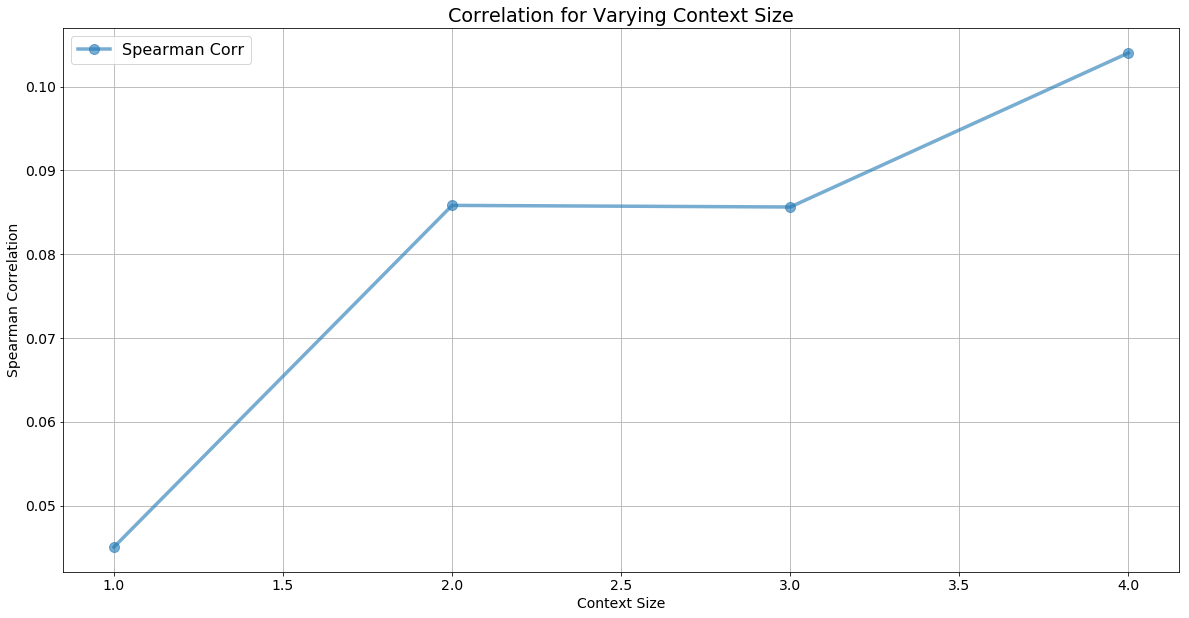

In [305]:
s = [spearman_c1, spearman_c2, spearman_c3, spearman_c4]
c = range(1,5)
plt.figure(figsize=(20,10))
plt.plot(c, [x[0] for x in s], linewidth=3.5, alpha=0.6,
         label="Spearman Corr", marker="o", markersize=10)

plt.rcParams["font.size"] = 16
plt.xlabel("Context Size")
plt.ylabel("Spearman Correlation")
plt.title("Correlation for Varying Context Size")

plt.grid()
plt.legend()


## Discussion

__c__. Briefly discuss the pros and cons of varying 

    I.  the context size 
    II.  the vocabulary size 
    III. using bigrams instead of unigrams 
    IV. using subword tokens instead of words. [8 pts]

#### I. Context Size

#### II. Vocabulary Size

#### III. Using Bigrams

#### IV. Using Subword Tokens

## Part 2: Pointwise Mutual Information [20 pts]

In lecture, we introduced __pointwise mutual information__ (PMI), which addresses the issue of normalization removing information about absolute magnitudes of counts. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell.

### PMI

__a__. Implement `pmi`, a function which takes in a co-occurence matrix and returns the matrix with PMI normalization applied. [15 pts]

In [38]:
def pmi(mat):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
    """    
    raise NotImplementedError

Apply PMI to the co-occurence matrix computed above with `context_size=1`. What is the PMI between the words "the" and "end"?

### PPMI

__b__. We also consider an extension of PMI, positive PMI (PPMI), that maps all negative PMI values to 0.0 ([Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization)). 
Write `ppmi`, which is the same as `pmi` except it applies PPMI instead of PMI (feel free to implement it as an option of `pmi`). What is the PMI of the words "the" and "start"? The PPMI? [5 pts]

## Part 3: Analyzing PMI [25 pts]

### Reweight Matrix

__a__. Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `ppmi`. 

    I. What is the value obtained for cell `[0,0]`, and 
    II. (ii) give a brief description for what is likely problematic about this value. [10 pts]

### Dealing with the Problematic Value
__b__. Give a suggestion for dealing with the problematic value and explain why it deals with this. Demonstrate your suggestion empirically [10 pts]

### PMI for Word-Word Co-occurence Matrix
__c__. Consider starting with a word-word co-occurence matrix and apply PMI to this matrix. 

        I. Which of the following describe the resulting vectors: sparse, dense, high-dimensional, low-dimensional
        II. If you wanted the opposite style of representation, what could you do? [5 pts]


## Part 4: Word Analogy Evaluation [25 pts]

Word analogies provide another kind of evaluation for distributed representations. Here, we are given three vectors A, B, and C, in the relationship

_A is to B as C is to __ _

and asked to identify the fourth that completes the analogy. These analogies are by and large substantially easier than the classic brain-teaser analogies that used to appear on tests like the SAT, but it's still an interesting, demanding
task. 

The core idea is that we make predictions by creating the vector

$$(A - B) + C$$ 

and then ranking all vectors based on their distance from this new vector, choosing the closest as our prediction.

### Analogy Completion
__a__. Implement the function `analogy_completion`. [9 pts]

In [ ]:
def analogy_completion(a, b, c, mat):
    """Compute ? in 
    a is to b as c is to ? 
    as the closest to (b-a) + c
    """
    raise NotImplementedError

### GloVe
__b__. Our simple word embeddings likely won't perform well on this task. Let's instead look at some high quality pretrained word embeddings. Write code to load 300-dimensional [GloVe word embeddings](http://nlp.stanford.edu/data/glove.840B.300d.zip) trained on 840B tokens. Each line of the file is formatted as a word followed by 300 floats that make up its corresponding word embedding (all space delimited). The entries of GloVe word embeddings are not counts, but instead are learned via machine learning. Use your `analogy_completion` code to complete the following analogies using the GloVe word embeddings. [6 pts]

- "Beijing" is to "China" as "Paris" is to ?
- "gold" is to "first" as "silver" is to ?
- "Italian" is to "mozzarella" as "American" is to ?
- "research" is to "fun" as "engineering" is to ?

### Evaluate GloVe
c. Let's get a more quantitative, aggregate sense of the quality of GloVe embeddings. Load the analogies from `gram6-nationality-adjective.txt` and evaluate GloVe embeddings. Report the mean reciprocal rank of the correct answer (the last word on each line) for each analogy. [10 pts]

__Solution__

In [13]:
def analogy_evaluation(glove_vecs, test_file, verbose=False):
    """Basic analogies evaluation for a file `src_filename `
    in `question-data/`.
    
    Parameters
    ----------    
    mat : 2d np.array
        The VSM being evaluated.
        
    rownames : list of str
        The names of the rows in `mat`.
        
    src_filename : str
        Basename of the file to be evaluated. It's assumed to be in
        `vsmdata_home`/question-data.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors.
    
    Returns
    -------
    (float, float)
        The first is the mean reciprocal rank of the predictions and 
        the second is the accuracy of the predictions.
    
    """
    raise NotImplementedError

In [16]:
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

(0.9391509433962264, defaultdict(int, {True: 97, False: 9}))